In [1]:
import cv2 
import os 
import numpy as np 
from random import shuffle 
from tqdm import tqdm 
import pandas as pd
import matplotlib.pyplot as plt

import tflearn 
from tflearn.layers.conv import conv_2d, max_pool_2d 
from tflearn.layers.core import input_data, dropout, fully_connected 
from tflearn.layers.estimator import regression 
import tensorflow as tf 
tf.reset_default_graph() 
from tflearn.data_preprocessing import ImagePreprocessing
from tflearn.data_augmentation import ImageAugmentation

import numpy as np
# save np.load
np_load_old = np.load

# modify the default parameters of np.load
np.load = lambda *a, **k: np_load_old(*a, allow_pickle = True, **k)

curses is not supported on this machine (please install/reinstall curses for an optimal experience)








In [2]:
train_categories = pd.read_csv('train.csv')
emergency = train_categories.loc[(train_categories['emergency_or_not'] == 1), 'image_names'].values.tolist()
not_emergency = train_categories.loc[(train_categories['emergency_or_not'] == 0), 'image_names'].values.tolist()
location = 'C:\\Users\\ak19919\\Downloads\\Github\\Analytics-Vidya\\janata-hack_computer_vision_hackathon\\images'
train_images = train_categories.image_names.values.tolist()
test_images = pd.read_csv('test.csv')
testImages = test_images.image_names.values.tolist()

In [3]:
IMG_SIZE = 48
LR = 1e-3
model_name = 'classify_emergency_vehicles-{}-{}.model'.format(LR, '6conv-basic')

In [4]:
def label_img(img):
    # One hot encoder 
    if str(img) in emergency: return [1, 0]
    elif str(img) in not_emergency: return [0, 1]

In [5]:
def create_train_data(): 
    # Creating an empty list where we should store the training data 
    # after a little preprocessing of the data 
    train_data = [] 
  
    # tqdm is only used for interactive loading 
    # loading the training data 
    for img in tqdm(train_images):
  
        # labeling the images 
        label = label_img(img) 
  
        path = os.path.join(location, img) 
  
        # loading the image from the path and then converting them into 
        # greyscale for easier covnet prob 
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
  
        # resizing the image for processing them in the covnet 
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE)) 
  
        # final step-forming the training data list with numpy array of the images 
        train_data.append([np.array(img), np.array(label)]) 
  
    # shuffling of the training data to preserve the random state of our data 
    shuffle(train_data) 
  
    # saving our trained data for further uses if required 
    np.save('train_data.npy', train_data) 
    return train_data

In [6]:
def process_test_data(): 
    test_data = [] 
    for img in tqdm(testImages): 
        path = os.path.join(location, img) 
        img_num = img.split('.')[0] 
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE) 
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE)) 
        test_data.append([np.array(img), img_num]) 
          
    shuffle(test_data) 
    np.save('test_data.npy', test_data) 
    return test_data

In [7]:
train_data = create_train_data() 
test_data = process_test_data() 

100%|███████████████████████████████████████████████████████████████████████████████| 706/706 [00:02<00:00, 240.05it/s]


In [8]:
convnet = input_data(shape =[None, IMG_SIZE, IMG_SIZE, 1], name ='input') 
  
convnet = conv_2d(convnet, 32, 5, activation ='relu') 
convnet = max_pool_2d(convnet, 5) 
  
convnet = conv_2d(convnet, 64, 5, activation ='relu') 
convnet = max_pool_2d(convnet, 5) 
  
convnet = conv_2d(convnet, 128, 5, activation ='relu') 
convnet = max_pool_2d(convnet, 5) 
  
convnet = conv_2d(convnet, 64, 5, activation ='relu') 
convnet = max_pool_2d(convnet, 5) 
  
convnet = conv_2d(convnet, 32, 5, activation ='relu') 
convnet = max_pool_2d(convnet, 5) 
  
convnet = fully_connected(convnet, 1024, activation ='relu') 
convnet = dropout(convnet, 0.8) 
  
convnet = fully_connected(convnet, 2, activation ='softmax') 
convnet = regression(convnet, optimizer ='adam', learning_rate = LR, 
      loss ='categorical_crossentropy', name ='targets') 
  
model = tflearn.DNN(convnet, tensorboard_dir ='log')


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
keep_dims is deprecated, use keepdims instead

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



In [9]:
train = train_data[:-330]
test = train_data[-330:]
  
'''Setting up the features and lables'''
# X-Features & Y-Labels 
  
X = np.array([i[0] for i in train]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
Y = [i[1] for i in train]
test_x = np.array([i[0] for i in test]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
test_y = [i[1] for i in test]

In [10]:
'''Fitting the data into our model'''
# epoch = 5 taken 
model.fit({'input': X}, {'targets': Y}, n_epoch = 30,  
    validation_set =({'input': test_x}, {'targets': test_y}),  
    snapshot_step = 500, show_metric = True, run_id = model_name) 
model.save(model_name)

Training Step: 629  | total loss: 0.06412 | time: 3.335s
| Adam | epoch: 030 | loss: 0.06412 - acc: 0.9867 -- iter: 1280/1316
Training Step: 630  | total loss: 0.05961 | time: 4.676s
| Adam | epoch: 030 | loss: 0.05961 - acc: 0.9865 | val_loss: 1.16360 - val_acc: 0.7818 -- iter: 1316/1316
--
INFO:tensorflow:C:\Users\ak19919\Downloads\Github\Analytics-Vidya\janata-hack_computer_vision_hackathon\classify_emergency_vehicles-0.001-6conv-basic.model is not in all_model_checkpoint_paths. Manually adding it.


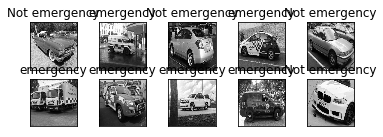

In [11]:
test_data = np.load('test_data.npy')
  
fig = plt.figure() 
  
for num, data in enumerate(test_data[:10]):
    # cat: [1, 0] 
    # dog: [0, 1] 
      
    img_num = data[1] 
    img_data = data[0] 
      
    y = fig.add_subplot(4, 5, num + 1)
    orig = img_data 
    data = img_data.reshape(IMG_SIZE, IMG_SIZE, 1) 
  
    # model_out = model.predict([data])[0]
    model_out = model.predict([data])[0]
      
    if np.argmax(model_out) == 1: str_label ='Not emergency'
    else: str_label ='emergency'
          
    y.imshow(orig, cmap ='gray') 
    plt.title(str_label) 
    y.axes.get_xaxis().set_visible(False) 
    y.axes.get_yaxis().set_visible(False) 
plt.show() 

In [12]:
test_data = np.load('test_data.npy')
results = {}
for num, data in enumerate(test_data):
    img_num = data[1]
    img_data = data[0]
    orig = img_data
    data = img_data.reshape(IMG_SIZE, IMG_SIZE, 1)

    # model_out = model.predict([data])[0]
    model_out = model.predict([data])[0]
    results.update({str(img_num) + '.jpg': np.argmax(model_out)})

In [13]:
Results = pd.DataFrame(results.items(), columns = ['image_names', 'emergency_or_not'])

In [14]:
final_submission = pd.merge(test_images, Results, on = ['image_names'])
final_submission.to_csv('submission_2.csv', index = False)